# Friends-of-Friends Catalog from Horizon Run 4 Simulation 

# Introduction

<font size="3"> We provide a FoF halo catalog at z = 0 from the Horizon Run 4 Simulation (Kim, Park, L'Huillier & Hong, 2015, JKAS, 48, 123). The basic parameters and propertis about the Horizon Run 4 can be found at <a href="http://sdss.kias.re.kr/eostm/halo.php">http://sdss.kias.re.kr/eostm/halo.php</a>. 
</font>

<br>

<font size="3">
    On this webpage, we specifically release the catalog in <em>parquet</em> format, commonly used in big data platforms, and briefly demonstrate how to handle this big catalog using the modern big data platform, <em>Apache Spark</em>. The download link for the parquet table is <a href="./hr4-fof-halo-z0.parquet.snappy">here</a>.
</font> 

<br>
    
<font size="3">FYI, <em>Apache Parquet</em> is a columnar storage format available to any project in the Hadoop ecosystem, regardless of the choice of data processing framework, data model or programming language. The details about <em>Apache Parquet</em> can be found at  <a href="https://parquet.apache.org/">https://parquet.apache.org/</a></font> 
    


# Demonstration: Handling Big Catalogs using Apache Spark

## [1] How to write a `csv` in `parquet` using Apache Spark

> Before demonstrating how to handle big parquet tables, we briefly show how to save a `csv` file as a `parquet` table. Though the `csv` format is human-readable and easy to read and save *structured data sets*, I strongly recommend to use `parquet` when handling Big Data for many good reasons. 

### Import basic libraries

In [1]:
# Basic common libraries
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import gc


In [2]:
# Basic PySpark Libraries 
from pyspark import SparkContext   
from pyspark.sql import SQLContext

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W

# Initializing Spark Shell 
# This initialization process may vary for different cloud/on-premise services.
sqlsc = SQLContext(sc)
sc.setCheckpointDir("hdfs://master:54310/tmp/spark/checkpoints")

In [3]:
# Enabling Apache Arrow 
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

### Read the data 

In [4]:
# define the schema before reading the csv file
halo_schema = T.StructType([ \
                            T.StructField('haloid', T.IntegerType(), False), \
                            T.StructField('px', T.FloatType(), False), \
                            T.StructField('py', T.FloatType(), False), \
                            T.StructField('pz', T.FloatType(), False), \
                            T.StructField('vx', T.FloatType(), False), \
                            T.StructField('vy', T.FloatType(), False), \
                            T.StructField('vz', T.FloatType(), False), \
                            T.StructField('halomass', T.FloatType(), False), \
                          ])

In [5]:
%%time
halodf = sqlsc.read.csv("hdfs://master:54310/data/cosmo/hr4/halo_z0.csv",\
                        header=False, schema = halo_schema)

CPU times: user 6.55 ms, sys: 0 ns, total: 6.55 ms
Wall time: 1.74 s


In [6]:
halodf.show(3,truncate=True)

+---------+---------+---------+---------+----------+----------+---------+-------------+
|   haloid|       px|       py|       pz|        vx|        vy|       vz|     halomass|
+---------+---------+---------+---------+----------+----------+---------+-------------+
|322225520|106.23875|2820.2603|310.53067|   -593.39|  42.42728|117.49196|3.29162502E14|
|127093960|1015.0091| 3070.103|2687.5447|-361.36716| -34.88201|   980.29|  5.796312E14|
| 95586173|1150.7571| 656.3275|195.96417|  295.5281|-117.53244|203.30292| 7.4870011E14|
+---------+---------+---------+---------+----------+----------+---------+-------------+
only showing top 3 rows



In [7]:
halodf.printSchema()

root
 |-- haloid: integer (nullable = true)
 |-- px: float (nullable = true)
 |-- py: float (nullable = true)
 |-- pz: float (nullable = true)
 |-- vx: float (nullable = true)
 |-- vy: float (nullable = true)
 |-- vz: float (nullable = true)
 |-- halomass: float (nullable = true)



### Save it as a parquet

In [8]:
import pyarrow as pa
import pyarrow.parquet as pq

In [9]:
%%time
halodf \
    .write.option("compression", "snappy") \
    .mode("overwrite") \
    .save("hdfs://master:54310/data/cosmo/hr4/hr4-fof-halo-z0.parquet.snappy")

CPU times: user 17.7 ms, sys: 0 ns, total: 17.7 ms
Wall time: 2min 8s


## [2] How to read and analyze this big `parquet` table

### Read the parquet table to a dataframe `df`

In [4]:
%%time
df = spark.read.parquet("hdfs://master:54310/data/cosmo/hr4/hr4-fof-halo-z0.parquet.snappy")

CPU times: user 2.55 ms, sys: 1.84 ms, total: 4.4 ms
Wall time: 3.44 s


### Show the basic statistics using `.describe()`

#### The default PySpark output using `.describe().show()`. But this does not look pretty. 

In [6]:
%%time
df.describe().show()

+-------+--------------------+------------------+------------------+------------------+--------------------+--------------------+------------------+--------------------+
|summary|              haloid|                px|                py|                pz|                  vx|                  vy|                vz|            halomass|
+-------+--------------------+------------------+------------------+------------------+--------------------+--------------------+------------------+--------------------+
|  count|           362123180|         362123180|         362123180|         362123180|           362123180|           362123180|         362123180|           362123180|
|   mean|1.8106158949999997E8|1574.9487699428894|1574.5065974890745|1575.7579631810702|0.059271831673608597|0.032516741919499166|0.0419704858281297|2.309020271127732...|
| stddev|1.0453595787073967E8| 909.2939271893533| 909.5066398131257| 909.4171871354722|   291.9076258781867|  292.21719836894647| 291.0346444428143|1.

#### Print the results using a `pandas` dataframe

In [7]:
%%time
df.describe().toPandas().set_index('summary').transpose()

/home/shong/anaconda3/lib/python3.7/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead
  warnings.warn(msg, FutureWarning)


CPU times: user 112 ms, sys: 16.5 ms, total: 129 ms
Wall time: 2min 24s


summary,count,mean,stddev,min,max
haloid,362123180,1.810615894999999E8,1.0453595787073962E8,0,362123179
px,362123180,1574.948769942889,909.2939271893531,-3.628511,3149.9463
py,362123180,1574.5065974890751,909.5066398131257,-3.603208,3149.9321
pz,362123180,1575.7579631810695,909.4171871354728,0.163826,3154.1765
vx,362123180,0.05927183167360858,291.9076258781867,-2907.2056,2742.1318
vy,362123180,0.03251674191949915,292.21719836894647,-2714.5393,2738.2966
vz,362123180,0.041970485828129664,291.0346444428143,-2624.5703,2734.925
halomass,362123180,2.3090202711277324E12,1.3233390075706506E13,2.70611202E11,5.6967899E15


> The total number of halos is over 362 millions. 

### Visualize the halo distribution

#### Select a 2 Mpc slice as `slicedf`, where `df.pz < 2.0` 

In [8]:
%%time
slicedf = df.filter(df.pz < 2.0).select(['px','py','pz'])

CPU times: user 3.61 ms, sys: 3.77 ms, total: 7.38 ms
Wall time: 315 ms


In [9]:
slicedf.printSchema()

root
 |-- px: float (nullable = true)
 |-- py: float (nullable = true)
 |-- pz: float (nullable = true)



In [10]:
%%time
slicedf = df.filter(df.pz < 2.0).select(['px','py','pz']).toPandas()

CPU times: user 18.8 ms, sys: 11.2 ms, total: 30 ms
Wall time: 1.52 s


In [11]:
len(slicedf.index)

193071

#### Plot this halo slice

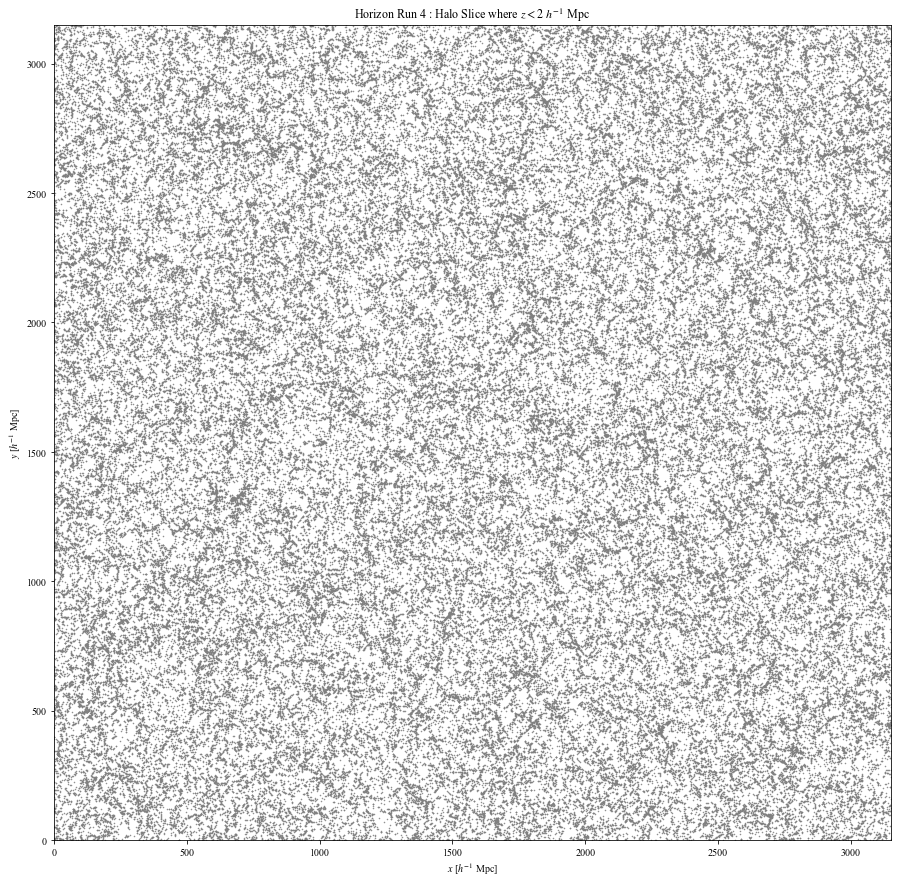

In [12]:
# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'


fig = plt.figure(figsize=(15,15))

plt.axis([0,3150,0,3150])
#plt.axes().set_aspect('equal', 'datalim')
plt.title(r'Horizon Run 4 : Halo Slice where $z < 2$ $h^{-1}$ Mpc')
plt.xlabel(r'$x$ [$h^{-1}$ Mpc]')
plt.ylabel(r'$y$ [$h^{-1}$ Mpc]')
plt.scatter(slicedf.px.values,slicedf.py.values,marker=".",s=1.0,color='grey')


plt.show()


## [3] Practical Example 

### We will extract $31^3$ sub-volumes with the size, $L_{sub} = 100 h^{-1}$Mpc, from the whole HR4 catalog. 

> We will generate a training sample of spatial halo distributions with a box size, [$100 h^{-1}$Mpc]$^3$, from the whole halo catalog. The extracted sample of $31^3 = 29791$ sub-boxes is large enough to be used as a training sample for Deep Learning projects.  

#### [3.1] Assign a division (or, grid) index to each halo. 

In [15]:
df.show(3,truncate=True)

+---------+---------+---------+---------+----------+----------+---------+-------------+
|   haloid|       px|       py|       pz|        vx|        vy|       vz|     halomass|
+---------+---------+---------+---------+----------+----------+---------+-------------+
|322225520|106.23875|2820.2603|310.53067|   -593.39|  42.42728|117.49196|3.29162502E14|
|127093960|1015.0091| 3070.103|2687.5447|-361.36716| -34.88201|   980.29|  5.796312E14|
| 95586173|1150.7571| 656.3275|195.96417|  295.5281|-117.53244|203.30292| 7.4870011E14|
+---------+---------+---------+---------+----------+----------+---------+-------------+
only showing top 3 rows



In [16]:
lsys = 3150.0
mlength = 100.0
mdiv = 31

In [17]:
%%time
subdf = df \
        .withColumn('ixdiv',F.floor(df.px/mlength)) \
        .withColumn('iydiv',F.floor(df.py/mlength)) \
        .withColumn('izdiv',F.floor(df.pz/mlength))

CPU times: user 2.18 ms, sys: 3.41 ms, total: 5.59 ms
Wall time: 38 ms


In [18]:
%%time
# Some buggy negative coordinate values. We replace these negative indices with `31`
subdf = subdf \
        .withColumn('ixdiv',F.when(subdf.ixdiv == -1, 31).otherwise(subdf.ixdiv)) \
        .withColumn('iydiv',F.when(subdf.iydiv == -1, 31).otherwise(subdf.iydiv)) \
        .withColumn('izdiv',F.when(subdf.izdiv == -1, 31).otherwise(subdf.izdiv))

CPU times: user 7.62 ms, sys: 3.89 ms, total: 11.5 ms
Wall time: 76.7 ms


> IMPORTANT NOTE: Most Big Data plaforms use the scheme, called **lazy evaluation**, not easy to be explained in this short notebook. Please be advised by this link for details: https://en.wikipedia.org/wiki/Lazy_evaluation#:~:text=In%20programming%20language%20theory%2C%20lazy,avoids%20repeated%20evaluations%20(sharing).

In [19]:
subdf.cache()

DataFrame[haloid: int, px: float, py: float, pz: float, vx: float, vy: float, vz: float, halomass: float, ixdiv: bigint, iydiv: bigint, izdiv: bigint]

In [22]:
%%time
subdf.show(10,truncate=True)

+---------+---------+---------+---------+----------+----------+----------+-------------+-----+-----+-----+
|   haloid|       px|       py|       pz|        vx|        vy|        vz|     halomass|ixdiv|iydiv|izdiv|
+---------+---------+---------+---------+----------+----------+----------+-------------+-----+-----+-----+
|322225520|106.23875|2820.2603|310.53067|   -593.39|  42.42728| 117.49196|3.29162502E14|    1|   28|    3|
|127093960|1015.0091| 3070.103|2687.5447|-361.36716| -34.88201|    980.29|  5.796312E14|   10|   30|   26|
| 95586173|1150.7571| 656.3275|195.96417|  295.5281|-117.53244| 203.30292| 7.4870011E14|   11|    6|    1|
|248741686|2745.5166|2020.5542|839.78326| 149.90967| -512.4188|-661.92096|1.55998296E14|   27|   20|    8|
|292585703|1129.6155|1974.3558|1253.1699|-332.87952|-214.82208| -405.1472|3.26916402E14|   11|   19|   12|
|274107747|589.67566|2289.6702|2542.1628|-151.16937| 267.27695|-358.16284|2.77196099E14|    5|   22|   25|
| 59442017|1486.9604| 2534.887| 2683.

#### Sanity Check for `idiv` values

In [23]:
%%time
ixmin = subdf.agg({"ixdiv":"min"}).collect()[0][0]
iymin = subdf.agg({"iydiv":"min"}).collect()[0][0]
izmin = subdf.agg({"izdiv":"min"}).collect()[0][0]
print("idiv code min = ", ixmin," ",iymin," ",izmin)

idiv code min =  0   0   0
CPU times: user 18.5 ms, sys: 3.45 ms, total: 22 ms
Wall time: 27.3 s


In [24]:
%%time
ixmax = subdf.agg({"ixdiv":"max"}).collect()[0][0]
iymax = subdf.agg({"iydiv":"max"}).collect()[0][0]
izmax = subdf.agg({"izdiv":"max"}).collect()[0][0]
print("idiv code max = ", ixmax," ",iymax," ",izmax)

idiv code max =  31   31   31
CPU times: user 16 ms, sys: 3.99 ms, total: 20 ms
Wall time: 1.41 s


#### [3.2] Select top 1000 halos in mass for each subvolume, then merge them all into a single dataframe.  

In [23]:
%%time
#  ixdiv, iydiv, izdiv, from 0 to 30
#from tqdm import tqdm
idmax = 31 # idmax=31 == [0, ... ,30]
traindf = pd.DataFrame()
icounter = 0
numhalo = 2000 # how many halos, selected from each sub-volume
for ix in range(idmax):
    for iy in range(idmax):
        for iz in range(idmax):
            gc.collect()
            tmppd = subdf.filter((F.col('ixdiv') ==ix) & (F.col('iydiv') ==iy) & (F.col('izdiv') ==iz))\
                    .select('haloid','px','py','pz','halomass').toPandas()
            tmppd = tmppd.sort_values(by='halomass',ascending=False)[0:numhalo] #sort the DF based on halomass
            tmppd['isect'] = np.full(numhalo,icounter) #id for each section 
            
            traindf = pd.concat([traindf,tmppd])
            icounter = icounter + 1

CPU times: user 1d 2h 16min 41s, sys: 9h 19min 8s, total: 1d 11h 35min 49s
Wall time: 9h 55min 42s


> These triple loops are an ad-hoc implementation, since I only need to run this process once. If you find a better way to reduce the running time with more optimized codes, you can learn about `pandas udf`; especially, the `GROUPED_MAP`. This can boost up the speed to extract sub-volumes as grouped-maps. For details about `pandas udf`, https://databricks.com/blog/2017/10/30/introducing-vectorized-udfs-for-pyspark.html#:~:text=Grouped%20map%20Pandas%20UDFs%20first,as%20a%20new%20Spark%20DataFrame%20.  

In [24]:
traindf = traindf.reset_index(drop=True)

In [25]:
traindf.head(3)

,haloid,px,py,pz,halomass,isect
0,318792177,98.907692,47.874481,65.046234,3.037070e+14,0
1,7145778,0.998974,13.699450,33.076996,1.684916e+14,0
2,303802715,86.756271,74.397171,88.292831,1.273767e+14,0


In [26]:
# Save this train sample to a parquet table
pq.write_table(pa.Table.from_pandas(traindf), \
               'hdfs://master:54310/data/cosmo/hr4/hr4-z0-train.parquet.snappy', compression='snappy')